I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track of their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insights on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install praw duckdb jupysql bertopic groq pyabsa tqdm --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import os
from pprint import pprint
from tqdm import trange, tqdm, tqdm_notebook # progress bar for run time >30 min

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 
from math import pi
import plotly.express as px

# Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

# Named Entity Recognition
import spacy 
import requests 
from bs4 import BeautifulSoup
nlp = spacy.load("en_core_web_sm")
pd.set_option("display.max_rows", 200)

from spacy import displacy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Deploy Flask apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-07-12 23:24:52.380926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 23:24:52.381081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 23:24:52.549680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-12 23:25:32] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# YouTube and Reddit Data

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [4]:
user_secrets = UserSecretsClient()

In [5]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [6]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [7]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

author          published_at  like_count  \
6783            @kowotanya  2024-06-11T10:53:21Z           0   
953          @davidmbermeo  2024-06-13T01:00:17Z           0   
2461         @davidcai3600  2024-06-11T22:52:30Z           0   
7634         @xxseesxx9234  2024-06-11T09:22:04Z           0   
5399  @finalGambitShedinja  2024-06-11T13:24:48Z           0   

                                                                                                                                                      text  \
6783                                                                                And we laughed at Jack Ma when he talked about Alibaba Intelligence 💀😂   
953   No lie the verge video was next to your video. I clicked theirs and exited because I saw that it was a similar length and immediately clicked yours.   
2461                                                                                                                     huawei has had MathNote for years   
7634                                                                                      The name Apple intelligence sounds like a surveillance apparatus   
5399                                                                                                         ipad calculator before a new rihanna album :(   

         video_id  
6783  qkYoBNdcXBU  
953   qkYoBNdcXBU  
2461  qkYoBNdcXBU  
7634  qkYoBNdcXBU  
5399  qkYoBNdcXBU

In [8]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [9]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

author        published_at  like_count  \
8123     @user-ff7rj6dc5z 2024-06-11 08:45:47           0   
4827       @imbrenojansen 2024-06-11 14:29:32           0   
9476  @abrahamlincoln1600 2024-06-11 07:36:01           1   
1730            @613fredp 2024-06-12 05:59:29           0   
9622      @Moviemoment299 2024-06-11 07:30:12           0   

                                                                                                                                                                                                                                                                                                                                                                            text  \
8123                                                                                                                                                               Bro with ai only available on the most top end devices apple has now rendered my iPhone 15 and my iPad Pro 2020 kinda outdated and bro iPhone 15 is like the newest phone but still they aren’t supporting it   
4827                                                                                                                                                                                                                                        As an owner of an iPhone 14 Pro Max, the fact they're putting the whole AI things only on iPhone 15 Pro and on is kinda infuriating.   
9476                                                                                                                                                                                                                                                                                  Finally, an event where android users can’t even argue that they made some cool new stuff!   
1730  Lol like Google is behind on everything from their mobile and desktop OS'S and apple just crushes them each release - then android tries to fix their broken features by copying apple - not to mention their PR failure re AI and can't even come close to open AI yet a few years ago tried to sell us with fake AI which never existed. They are so complacent it's sad   
9622                                                                                                                                                                                                                                                                                                                                                        Updates I wait for 😊   

     youtube_channel published_at_date  published_at_month  
8123           MKBHD        2024-06-11                   6  
4827           MKBHD        2024-06-11                   6  
9476           MKBHD        2024-06-11                   6  
1730           MKBHD        2024-06-12                   6  
9622           MKBHD        2024-06-11                   6

In [10]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9822
The Verge     483
Name: count, dtype: int64

In [11]:
df0['app'] = 'YouTube'

In [12]:
len(df0)

10305

In [13]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [14]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [15]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [16]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [17]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         811   
1                   6         525   
2                   6         874   
3                   6         137   
4                   6          95   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [18]:
len(reddit_df)

1343

In [19]:
reddit_df['app'] = 'Reddit'

In [20]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [21]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [22]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [23]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11648

In [24]:
df.head()

author        published_at  like_count  \
0  @jonaspadberg7385 2024-07-11 21:58:34           0   
1            @haodev 2024-07-11 19:21:24           0   
2         @Lillylim1 2024-07-11 18:48:06           0   
3     @theclient6251 2024-07-11 05:09:51           0   
4          @NBGUYVER 2024-07-11 01:52:57           0   

                                                                                                                                                     text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date  published_at_month      app  
0        2024-07-11                   7  YouTube  
1        2024-07-11                   7  YouTube  
2        2024-07-11                   7  YouTube  
3        2024-07-11                   7  YouTube  
4        2024-07-11                   7  YouTube

____
# Data Augmentation with Synonyms 
Future use. It was not used here given Groq's limitations and sufficient conclusions given volume of data retrieved.

In [25]:
# If there is not enough data, augment data with synonyms. 
# (This was explored since Groq API had issues with >100 predictons at one time.) 
# However, the code is below just in case it is needed in the future for better model training and therefore prediction. 
# At the same time, picking a model that understands variance in data is another approach at high inference accuracy.

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def replace_with_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            new_text.append(synonyms[0])  # Replace with the first synonym
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Load a pre-trained model for masked language modeling
unmasker = pipeline('fill-mask', model='bert-base-uncased')

def replace_with_contextual_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        if wordnet.synsets(word):  # Check if word has synonyms
            masked_text = text.replace(word, '[MASK]', 1)
            suggestions = unmasker(masked_text)
            best_synonym = suggestions[0]['token_str']  # Get the best synonym
            new_text.append(best_synonym)
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Test the functions
sample_text = "The quick brown fox jumps over the lazy dog."

# Basic synonym replacement
augmented_text = replace_with_synonyms(sample_text)
print("Basic Synonym Replacement:", augmented_text)

# Contextual synonym replacement
contextual_augmented_text = replace_with_contextual_synonyms(sample_text)
print("Contextual Synonym Replacement:", contextual_augmented_text)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1107: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/lexnames'>
  for i, line in enumerate(self.open('lexnames')):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adj'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adv'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.noun'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/n

Basic Synonym Replacement: The quickly dark-brown fuddle derail complete the faineant dog.
Contextual Synonym Replacement: The little thinking cat watched at the little dog.


Both are not that great because these sentences would not be used in real life. I would use Groq again in order to have better quality synonyms. 

In [26]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            I am trying to test out some data augmentation methods using word replacement with synonyms. 
            Given this sentence, please create an alternative or alternatives, but similar sentence using synonyms:
            The quick brown fox jumps over the lazy dog.
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

'What a classic sentence!\n\nI\'d be happy to help you with some synonyms. Here are a few alternatives:\n\n1. **The swift reddish-orange fox leaps over the sluggish canine.**\n\n* "quick" -> "swift"\n* "brown" -> "reddish-orange" (since "brown" is a broad color term, I chose a more specific synonym)\n* "jumps" -> "leaps" (a more vivid verb)\n* "lazy" -> "sluggish"\n* "dog" -> "canine"\n\n2. **The rapid rust-colored fox bounds over the indolent hound.**\n\n* "quick" -> "rapid"\n* "brown" -> "rust-colored"\n* "jumps" -> "bounds" (another action word)\n* "lazy" -> "indolent"\n* "dog" -> "hound"\n\n3. **The swift sandy fox springs over the lethargic pup.**\n\n* "quick" -> "swift"\n* "brown" -> "sandy" (a more specific color term)\n* "jumps" -> "springs" (another verb)\n* "lazy" -> "lethargic"\n* "dog" -> "pup"\n\nThese are just a few examples, and there are many more synonyms you could use to create additional variations. I hope this helps you with your data augmentation project!'

Awesome, just as I predicted, LLM is much better than NLTK algorithms. :)
____

# BERTopic Modeling

In [27]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-12 23:26:38,280 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/364 [00:00<?, ?it/s]

2024-07-12 23:28:13,075 - BERTopic - Embedding - Completed ✓
2024-07-12 23:28:13,077 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-12 23:28:48,311 - BERTopic - Dimensionality - Completed ✓
2024-07-12 23:28:48,313 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-12 23:28:57,186 - BERTopic - Cluster - Completed ✓
2024-07-12 23:28:57,195 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-12 23:29:15,216 - BERTopic - Representation - Completed ✓


Topic  Count                                                    Name  \
0       -1   2461                            -1_ai_google_features_iphone   
1        0    998                     0_calculator_ipad_handwriting_maths   
2        1    569                                   1_apple_tech_news_buy   
3        2    473                    2_siri_typing_accessibility_settings   
4        3    361                             3_notes_mkbhd_event_updates   
5        4    287                              4_icons_change_dark_colors   
6        5    233                            5_ios_features_iphones_years   
7        6    225                                      6_15_pro_iphone_ai   
8        7    213                                7_s24_ultra_galaxy_notes   
9        8    208                          8_android_apple_years_features   
10       9    199                              9_ai_tech_times_definition   
11      10    190                   10_intelligence_artificial_apple_term   
12      11    190                                 11_ios18_beta_update_17   
13      12    181                           12_tinder_grindr_wives_folder   
14      13    175                          13_chatgpt_gpt_integration_api   
15      14    169                      14_intelligence_cringe_meme_insult   
16      15    155                                    15_11_07_useless_воу   
17      16    153                                16_ipados_power_pro_file   
18      17    151                              17_privacy_data_cloud_sent   
19      18    131                  18_lol_epic_sucks_fuuuutttuuurreeeeeee   
20      19    121                                19_emojis_robber_gen_hat   
21      20    119                          20_mirroring_mac_remote_huawei   
22      21    115                           21_ugly_ruin_design_customize   
23      22    109                                  22_15_apple_models_a17   
24      23    100                                23_15_iphone_pro_battery   
25      24     84                      24_lighting_grading_sunset_setting   
26      25     83              25_subscribers_youtube_apple_presentations   
27      26     82                             26_vr_announced_3d_visionos   
28      27     78                               27_openai_elon_musk_train   
29      28     77                            28_marques_samsung_notes_gal   
30      29     75                       29_marques_thumbnail_pedro_batman   
31      30     71                  30_images_artists_generative_copyright   
32      31     69                                31_ai_apple_compete_tech   
33      32     66                   32_text_imessage_scheduling_shortcuts   
34      33     66                            33_thanks_love_brighter_vids   
35      34     65                        34_mkbhd_light_studio_thumbnails   
36      35     64                           35_song_intros_eminem_houdini   
37      36     62                       36_keyboard_unplug_gesture_button   
38      37     58                                37_db_bvg_bahn_transport   
39      38     56               38_customization_options_people_ringtones   
40      39     56                            39_keynote_5g_platforms_fest   
41      40     55                     40_chapters_계선기_backgraund_apostasy   
42      41     51                           41_android_wow_teaser_15years   
43      42     51                  42_upgrade_supported_generations_14pro   
44      43     51                       43_genmojis_uncanny_stickers_send   
45      44     51                  44_available_equalizer_wavelettt_2024_   
46      45     50                            45_satellite_sms_garmin_wifi   
47      46     50                        46_hotel_lighting_studio_manages   
48      47     48                         47_watchos_garmin_fitness_goals   
49      48     47                               48_homepods_siri_tbd_pods   
50      49     46                      49_organize_filter_recents_gallery   
5

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [28]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
# df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-12 23:29:44,043 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-12 23:29:54,500 - BERTopic - Dimensionality - Completed ✓
2024-07-12 23:29:54,503 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-12 23:30:02,397 - BERTopic - Cluster - Completed ✓
2024-07-12 23:30:02,416 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-12 23:30:20,156 - BERTopic - Representation - Completed ✓


CPU times: user 1min 42s, sys: 24.3 s, total: 2min 7s
Wall time: 1min 4s


Topic  Count  \
0       -1   4547   
1        0    660   
2        1    569   
3        2    504   
4        3    408   
5        4    235   
6        5    201   
7        6    177   
8        7    173   
9        8    171   
10       9    166   
11      10    126   
12      11    124   
13      12    115   
14      13    104   
15      14     85   
16      15     85   
17      16     82   
18      17     81   
19      18     80   
20      19     80   
21      20     74   
22      21     70   
23      22     70   
24      23     70   
25      24     68   
26      25     68   
27      26     65   
28      27     58   
29      28     58   
30      29     56   
31      30     55   
32      31     55   
33      32     53   
34      33     53   
35      34     46   
36      35     45   
37      36     45   
38      37     44   
39      38     44   
40      39     42   
41      40     41   
42      41     40   
43      42     40   
44      43     39   
45      44     39   
46      45     38   
47      46     38   
48      47     37   
49      48     37   
50      49     37   
51      50     37   
52      51     36   
53      52     36   
54      53     36   
55      54     35   
56      55     35   
57      56     32   
58      57     31   
59      58     30   
60      59     29   
61      60     29   
62      61     28   
63      62     28   
64      63     28   
65      64     28   
66      65     28   
67      66     28   
68      67     28   
69      68     28   
70      69     26   
71      70     25   
72      71     25   
73      72     24   
74      73     24   
75      74     24   
76      75     23   
77      76     23   
78      77     23   
79      78     22   
80      79     22   
81      80     22   
82      81     22   
83      82     21   
84      83     21   
85      84     21   
86      85     21   
87      86     20   
88      87     20   
89      88     20   
90      89     20   
91      90     20   
92      91     20   
93      92     19   
94      93     19   
95      94     19   
96      95     19   
97      96     18   
98      97     17   
99      98     17   
100     99     17   
101    100     16   
102    101     15   
103    102     15   
104    103     15   
105    104     15   
106    105     15   
107    106     15   

                                                            Name  \
0                                      -1_apple_ai_like_features   
1                                    0_samsung_s24_notes_marques   
2                                1_siri_type_accessibility_voice   
3                                               2_15_pro_plus_ai   
4                                3_icons_apps_widgets_homescreen   
5                                  4_calculator_app_pencil_maths   
6                                               5_ai_times_ml_ev   
7                                   6_privacy_openai_cloud_trust   
8                                    7_math_notes_kids_equations   
9                                      8_m4_ipados_macbook_doesn   
10                                         9_apple_shill_yada_នទ   
11                            10_emojis_custom_stickers_genmojis   
12                                    11_epic_gay_awesome_frills   
13                             12_mirroring_remote_vision_huawei   
14                                  13_tinder_grindr_wives_hides   
15                     14_calculator_wow_students_woooooooooooow   
16                              15_android_copying_trying_boomer   
17   16_backgraund_这就是中国全部手机公司市值的科技公司所做出来的创新_goobyeprivacy_hakka   
18                                 17_powered_2016_xiaomi_18mins   
19                                    18_intros_eminem_logics_85   
20                                      19_ios_closer_mt_welcome   
21                               20_oxymoron_agency_corny_insult   
22                                21_calculator_app_combines_cal   
23                              22_window_snapping_mac_rectangle   
24             

In [29]:
topic_model.get_topic(0) # top topic

[('samsung', 0.09508000014283226),
 ('s24', 0.0515421620182935),
 ('notes', 0.03684802994224744),
 ('marques', 0.029767112460139956),
 ('read', 0.02901567452076946),
 ('mkbhd', 0.02901367260570882),
 ('updates', 0.019583230605474244),
 ('event', 0.015452125934504995),
 ('funny', 0.015241973173446487),
 ('ios', 0.013140610304582925)]

These topics seem more interpretable due to better embeddings. (Also, there was an index shift with topic 0 being non-outlier topic, but most popular topic.)

## BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [30]:
topic_model.visualize_topics()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The biggest topic after the outlier topic was topic 0 centered on: ai, intelligence, apple, people and tech. I used the slider to move across topics. The highlighted bubble helps you see which topic you are examining. This is helpful if you cannot tell which topic you are on based on the slider ticks. When you hover over the bubble, you see the words associated with the topic.

In [31]:
topic_model.visualize_barchart(top_n_topics=8)

We see the top 8 topics and their associated words. The higher the score for a word, the more central it is to the topic. 

Huge wins for Apple were announcing their AI integrations, Siri upgrade, iPad calculator as well as their continual striving to keep their devices private and secure. Topics of critique were their icon customizations and need to have more innovation with their non-iPhone products.

In [32]:
topic_model.visualize_heatmap()

Cosine Similarity Matrix: This is a table where each cell (i, j) contains the cosine similarity between the embedding of topic i and the embedding of topic j. If the value is close to 1, it means those topics are very similar. If it's close to 0, they are quite different.

Heatmap: This is a graphical representation of the cosine similarity matrix. In a heatmap, colors are used to represent values in the matrix. Typically, darker colors might represent higher similarity (values closer to 1), while lighter colors represent lower similarity (values closer to 0).

___

This Similarity Matrix would be nice if it was broken down into smaller matrices, but the number of possible combinations would be reduced. When hovering over the darkest squares there are some interesting similar topics that are far away in index number, but words within topics were similar. For example, two topics (12 and 39) crossing with similarity score of: 0.879157 have these words in their topics: (12): calculator, app and yassss (39): ipad, students, calculator. Similarity is in excitement over new ipad calculator.

* Not sure what the benchmark is for good separation between topics. 
* Considering topics not along the diagonal are unique topics.
* Most topics are 0.4 or below in similarity score. This means there are nice distinct topics discovered under better embeddings and BERTopic model.

# Perform Sentiment and Emotion Classification

In [33]:
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Long comments cause error in model inference because model has cap in total number of tokens as input. To get arround this, will use a tokenizer to determine total tokens per comment. Then will summarize those comments that exceed input max token count. Will use LLM to summarize 
long comments. Finally, before sentiment inference, filter will be used to retain comments that only are below threshold for max token count.

In [34]:
# Need to make comments text as similar as text was for model's training for sentiment inference: remove HTML tags
# Using cased model so case-sentitive text used to train model. So for new data input, no need for lowering text.

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

author        published_at  like_count  \
0  @jonaspadberg7385 2024-07-11 21:58:34           0   
1            @haodev 2024-07-11 19:21:24           0   
2         @Lillylim1 2024-07-11 18:48:06           0   
3     @theclient6251 2024-07-11 05:09:51           0   
4          @NBGUYVER 2024-07-11 01:52:57           0   

                                                                                                                                                     text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date  published_at_month      app  \
0        2024-07-11                   7  YouTube   
1        2024-07-11                   7  YouTube   
2        2024-07-11                   7  YouTube   
3        2024-07-11                   7  YouTube   
4        2024-07-11                   7  YouTube   

                                                                                                                                           processed_text  
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D  
1                                                                                                                                "Apple Intelligence" 💀💀💀  
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.  
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉  
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️

In [35]:
%%time

# 1. Determine total tokens
# 2. Filter out comments that have max: 450 total tokens since tokenizer can add suffixes as a token. So buffering for that.
# 3. Summarize comments using Groq since losing richness of dataset if eliminated comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 2.38 s, sys: 4.01 ms, total: 2.38 s
Wall time: 2.43 s


author        published_at  like_count  \
0  @jonaspadberg7385 2024-07-11 21:58:34           0   
1            @haodev 2024-07-11 19:21:24           0   
2         @Lillylim1 2024-07-11 18:48:06           0   
3     @theclient6251 2024-07-11 05:09:51           0   
4          @NBGUYVER 2024-07-11 01:52:57           0   

                                                                                                                                                     text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date  published_at_month      app  \
0        2024-07-11                   7  YouTube   
1        2024-07-11                   7  YouTube   
2        2024-07-11                   7  YouTube   
3        2024-07-11                   7  YouTube   
4        2024-07-11                   7  YouTube   

                                                                                                                                           processed_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

   num_tokens  
0          22  
1           5  
2          23  
3          23  
4          31

In [36]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [37]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [38]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [39]:
# Testing
 
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here's a condensed version of the original comment in 15 sentences or less:\n\nI want to thank you for creating well-thought-out videos that provide tech news. As a software engineer, I appreciate your focus on technology. I have a suggestion to take your content to the next level: create a real tech news channel. This would make your channel a go-to source for tech news, like a CNN for technology. With a real tech news channel, you could hire anchors and conduct in-depth interviews with tech CEOs. This would be a profitable billion-dollar idea, and it's something that's needed in today's tech-savvy world.\n\nAs someone who has written to Apple for years, I've noticed that they've incorporated some of my ideas into their products. I've also learned a lot from watching your videos and appreciate your willingness to share knowledge. I think you, along with other tech influencers like Brian Tong and Engadget, could make this channel a reality. With a real tech news channel, we could have

In [40]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[0]

"Here's a condensed version of the original comment in 15 sentences or less:"

In [41]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[0]))

16

* [x] Now write up a function in order to loop through Pandas text column that has > 450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has <= 450 tokens
* [x] After verification, perform sentiment and emotion analysis using HF and Groq

In [42]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

In [43]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [44]:
condensed[1]

"The iPad calculator app announced at WWDC is a gimmick that won't be used in real-world scenarios. It allows users to give answers as they write down math questions, but this feature is limited to primary school level and can be easily replaced by physical calculators. The app's ability to support variables and equations is also limited, and it can't handle complex math problems. Apple is targeting students in classroom settings, but even then, physical calculators are better suited for exams. The app's features are nothing new and can be easily replicated by free software like Geogebra and Desmos. The physical calculator is just as good, if not better, than the iPad calculator for doing math. The features on the iPad are a complete gimmick and not worth the hype.\n\nOther examples of useless features include Samsung's AI updates, which are rarely used and don't make sense. The author argues that we should stop and reflect on how features would be translated to real-world use, rather 

In [45]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of > 450 token comment. Now let us make two lists into two Pandas columns. And then join this to the original df on the non-condensed text. This will create a df that has the original >= 450 tokens comments and the condensed version of long comments.

In [46]:
summarize_df['condensed_text'] = condensed

In [47]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [48]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                           processed_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  condensed_text  
0           None  
1           None  
2           None  
3           None  
4           None

In [49]:
#Checking that the join outputs same number of rows as original df
len(summarized_df)

11648

In [50]:
summarized_df.head(1)

author  like_count  \
0  @jonaspadberg7385           0   

                                                                                             original_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   

  published_at_date      app  \
0        2024-07-11  YouTube   

                                                                                            processed_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   

  condensed_text  
0           None

In [51]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1) # taking care of Groq API residue
inf_df.head(5)

author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                               final_text  
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D  
1                                                                                                                                "Apple Intelligence" 💀💀💀  
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.  
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉  
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️

In [52]:
inf_df.isnull().sum()

author               44
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [53]:
# Checking that comments that got condensed show up instead of original lengthy comment
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger          99   
2     hammerheadtiger          10   
3     hammerheadtiger           3   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         874   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Now let us re-tokenize the text to make sure we don't hit an error. 

In [54]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [55]:
query = """
select max(num_tokens) as max_tokens
from inf_df
"""
duckdb.query(query).df()

max_tokens
0         446

In [56]:
# If the sentiment classifier still has comments that exceed 512 tokens then need to summarize more comments.
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [57]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

author  like_count  \
0  @jonaspadberg7385           0   

                                                                                             original_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   

  published_at_date      app  \
0        2024-07-11  YouTube   

                                                                                                final_text  
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D

Great! Let us now perform sentiment and emotion classifications.

In [58]:
len(inf_df)-len(inf_df2) # Difference is small. So proceed.

0

## Sentiment Classification

In [59]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 16min 20s, sys: 3.02 s, total: 16min 23s
Wall time: 8min 12s


author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                               final_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

   num_tokens                                              sentiment  \
0          22   [{'label': 'positive', 'score': 0.6226241588592529}]   
1           5   [{'label': 'positive', 'score': 0.4598645269870758}]   
2          23   [{'label': 'neutral', 'score': 0.43470868468284607}]   
3          23   [{'label': 'positive', 'score': 0.5383099317550659}]   
4          31  [{'label': 'positive', 'score': 0.44983404874801636}]   

      label     score  
0  positive  0.622624  
1  positive  0.459865  
2   neutral  0.434709  
3  positive  0.538310  
4  positive  0.449834

In [60]:
inf_df2.tail(5)

author  like_count  \
11643    @mndlessdrwer           0   
11644    @hilal_younus           2   
11645  hammerheadtiger         874   
11646     KLM_SpitFire           2   
11647         kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<Axes: >

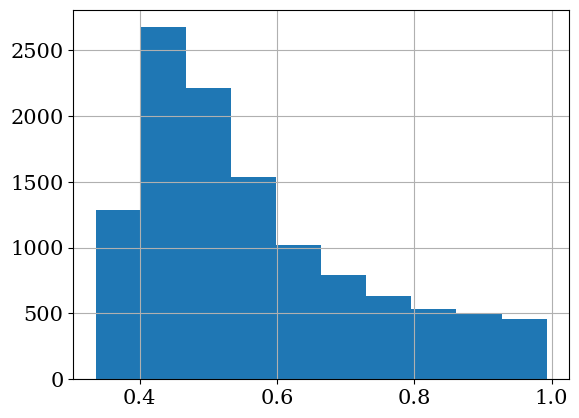

In [61]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see prediction confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. We will try to use Groq's fast model, which is likely to be more accurate given that the model is trained on more data.

In [62]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [63]:
inf_df2.head(1)

author  like_count  \
0  @jonaspadberg7385           0   

                                                                                             original_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   

  published_at_date      app  \
0        2024-07-11  YouTube   

                                                                                                final_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   

  hf_sentiment  hf_score  
0     positive  0.622624

# Groq API as Overall Text Sentiment Classifier
Using Groq as an overall sentiment classifier is much better. Unfortunately, it was not able to predict on 11,700 rows in one go even though data was chunked.

In [64]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [65]:
list_df[0].head()

author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                               final_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  hf_sentiment  hf_score  
0     positive  0.622624  
1     positive  0.459865  
2      neutral  0.434709  
3     positive  0.538310  
4     positive  0.449834

In [66]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentiment: negative, neutral or positive.
                Also provide confidence score as a percentage. 
                Output only as a Python string with sentiment and confidence score with comma in between. 
                Example output: neutral, 0.85
                Output needs to be the Python string only. 
                No need for introduction or explanation sentences. 
                Only return: 'neutral, 0.85'
                .
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 909 ms, sys: 70.4 ms, total: 979 ms
Wall time: 2min 45s


In [67]:
groq_sentiment[:10]

['positive, 0.97',
 'positive, 0.95',
 'positive, 0.65',
 'positive, 0.95',
 'positive, 0.95',
 'positive, 0.95',
 'neutral, 0.99',
 'negative, 0.78',
 'negative, 0.92',
 'positive, 1.00']

In [68]:
list_df[0]['final_text'][:10]

0                                                     The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D
1                                                                                                                                    "Apple Intelligence" 💀💀💀
2                                                               I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.
3                                                                  It's epic that you're reading your script from a Samsung phone. I see what you did there 😉
4      ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️
5                                                                                                                              The math notes I need so bad 😮
6                                                   

Groq definitely has better intelligence than HuggingFace's model. Most likely due to model architecture and training data. Really enjoying the accuracy of predictions, ease of API use and last but not least, the speed. 

* [x] add groq predictions to df
* [x] split string of prediction and prediction score into own columns
* [x] depict comparative graph between hf_score and groq_score
* [x] try to loop through predictions for ~11,700 row df

In [69]:
# add 100 predictions to 100-row df

list_df[0]['groq_sentiment'] = groq_sentiment
list_df[0].head()

author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                               final_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  hf_sentiment  hf_score  groq_sentiment  
0     positive  0.622624  positive, 0.97  
1     positive  0.459865  positive, 0.95  
2      neutral  0.434709  positive, 0.65  
3     positive  0.538310  positive, 0.95  
4     positive  0.449834  positive, 0.95

In [70]:
# split string on delimiter comma to create sentiment string column and prediction confidence score column
# cast score column as float

list_df[0][['groq_sentiment', 'groq_score']] = list_df[0]['groq_sentiment'].str.split(',', expand=True)
list_df[0].head(2)

author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   

                                                                                             original_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                 "Apple Intelligence" 💀💀💀   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   

                                                                                                final_text  \
0  The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                 "Apple Intelligence" 💀💀💀   

  hf_sentiment  hf_score groq_sentiment groq_score  
0     positive  0.622624       positive       0.97  
1     positive  0.459865       positive       0.95

In [71]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    58
neutral     21
negative    21
Name: count, dtype: int64

In [72]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95    22
0.75    10
0.92     9
0.9      7
0.65     7
0.99     6
0.93     5
0.98     5
0.63     4
0.78     2
0.7      2
0.74     2
0.96     2
0.91     2
0.73     2
1.0      2
0.85     1
0.90     1
0.62     1
0.6      1
0.97     1
0.25     1
0.88     1
0.81     1
0.76     1
1.00     1
0.94     1
Name: count, dtype: int64

In [73]:
# Clean up API output
list_df[0]['groq_sentiment'] = list_df[0]['groq_sentiment'].str.lower()

def remove_extra_quotes(col):
    return col.str.replace("'", "")
 
list_df[0]['groq_sentiment'] = remove_extra_quotes(list_df[0]['groq_sentiment'])
list_df[0]['groq_score'] = remove_extra_quotes(list_df[0]['groq_score'])

In [74]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    58
neutral     21
negative    21
Name: count, dtype: int64

In [75]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95    22
0.75    10
0.92     9
0.9      7
0.65     7
0.99     6
0.93     5
0.98     5
0.63     4
0.78     2
0.7      2
0.74     2
0.96     2
0.91     2
0.73     2
1.0      2
0.85     1
0.90     1
0.62     1
0.6      1
0.97     1
0.25     1
0.88     1
0.81     1
0.76     1
1.00     1
0.94     1
Name: count, dtype: int64

In [76]:
# Convert string into float
list_df[0]['groq_score'] = list_df[0]['groq_score'].astype(float)

<Axes: >

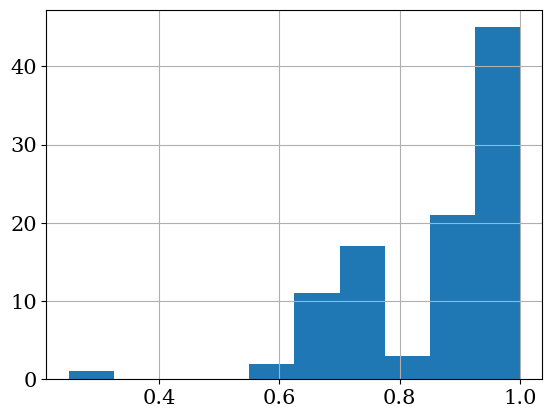

In [77]:
# Let's take a look at Groq's prediction score distribution.
# Hopefully, it is better than 0.4 range which was where HF sentiment hovered.

list_df[0]['groq_score'].hist()

Very nice. Confidence is mostly > 0.9!

____
# Groq at scale unfortunately does not work. 

I tried below algorithm but the output never came out after waiting for 4 hours of run time. This was the predicted computation time because took 2 minutes to do 100 rows of inference.

* [x] Just need to loop through list_df to create 117 diff prediction lists for each 100 block of rows
* [x] add each of the 117 lists to each df 
* [x] concat df's to blank df (11,700 total rows should be final df count)

In [78]:
# # fxn to get prediction per df with 100 rows only
# def groq_predictions(df):
    
#     #Checking to see if for loop without fxn works
#     groq_sentiment = [] # to store predictions
#     for text in df['final_text']: #using one chunk of 100 rows only, looping through text fed into model
#         chat_completion = client.chat.completions.create( #task performed on each comment
#             messages=[
#                 {
#                     "role": "user",
#                     "content": '''

#                     Please classify the following comment with a sentiment: negative, neutral or positive.
#                     Also provide confidence score as a percentage. 
#                     Output only as a Python string with sentiment and confidence score with comma in between. 
#                     Example output: neutral, 0.85
#                     Output needs to be the Python string only. 
#                     No need for introduction or explanation sentences. 
#                     Only return: 'neutral, 0.85'
#                     .
#                     This is the comment to classify sentiment on:
#                     '''
#                     + text,
#                 }
#             ],
#             model="llama3-8b-8192",
#         )
#         res = chat_completion.choices[0].message.content

#         groq_sentiment.append(res) #adding prediction to list to eventually append to df
    
#     return groq_sentiment

In [79]:
# # This whole thing will take >~4 hours...added progress bar to keep track

# df0 = pd.DataFrame()

# for df in tqdm_notebook(list_df, desc="PROGRESS"): # this will loop through 117 x 
#     # function to create predictons from 100 row df's final_text col
#     groq_sentiment = groq_predictions(df)

#     # add list to df
#     df['groq_sentiment'] = groq_sentiment

#     # add this to df0
#     df0 = pd.concat([df0, df])

# # output final big df. hopefully rows add up to: 117,000  
# df0.info()

Got this error after trying to do 11,700 predictions in 100-row chunks:

_InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}_

Based on their doc's: 503 Service Unavailable: The server is not ready to handle the request, often due to maintenance or overload. Wait before retrying the request.

After trying one more time, got the below error. 
_InternalServerError: upstream connect error or disconnect/reset before headers. reset reason: connection timeout_

Will just work with 100 predictions and PyABSA output. :)
___

## Emotion Classification

In [80]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [81]:
%%time

# Info pg: https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 15min 53s, sys: 4.03 s, total: 15min 57s
Wall time: 8min 3s


author  like_count  \
0  @jonaspadberg7385           0   
1            @haodev           0   
2         @Lillylim1           0   
3     @theclient6251           0   
4          @NBGUYVER           0   

                                                                                                                                            original_text  \
0                                                 The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D   
1                                                                                                                                "Apple Intelligence" 💀💀💀   
2                                                           I can’t decided which phone I want to pick with AI Samung Galaxy fold 6 or the latest Iphone.   
3                                                              It's epic that you're reading your script from a Samsung phone. I see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  published_at_date      app  \
0        2024-07-11  YouTube   
1        2024-07-11  YouTube   
2        2024-07-11  YouTube   
3        2024-07-11  YouTube   
4        2024-07-11  YouTube   

                                                                                                                                               final_text  \
0                                                 the most interesting thing is that marques has the german railway app on the homescreen of the pixel :d   
1                                                                                                                                "apple intelligence" 💀💀💀   
2                                                           i can’t decided which phone i want to pick with ai samung galaxy fold 6 or the latest iphone.   
3                                                              it's epic that you're reading your script from a samsung phone. i see what you did there 😉   
4  ios is going to finally allow you to fully customize your phone 👏 meanwhile, android users are trying to figure out if they want to fold or flip 🤷🏿‍♂️   

  hf_sentiment  hf_score hf_emotion  
0     positive  0.622624        joy  
1     positive  0.459865        joy  
2      neutral  0.434709        joy  
3     positive  0.538310        joy  
4     positive  0.449834        joy

Emotion classifier is somewhat off, but does help augment HF sentiment classification when both agree and are right in sentiment.

## Sentiment and Emotion over Time

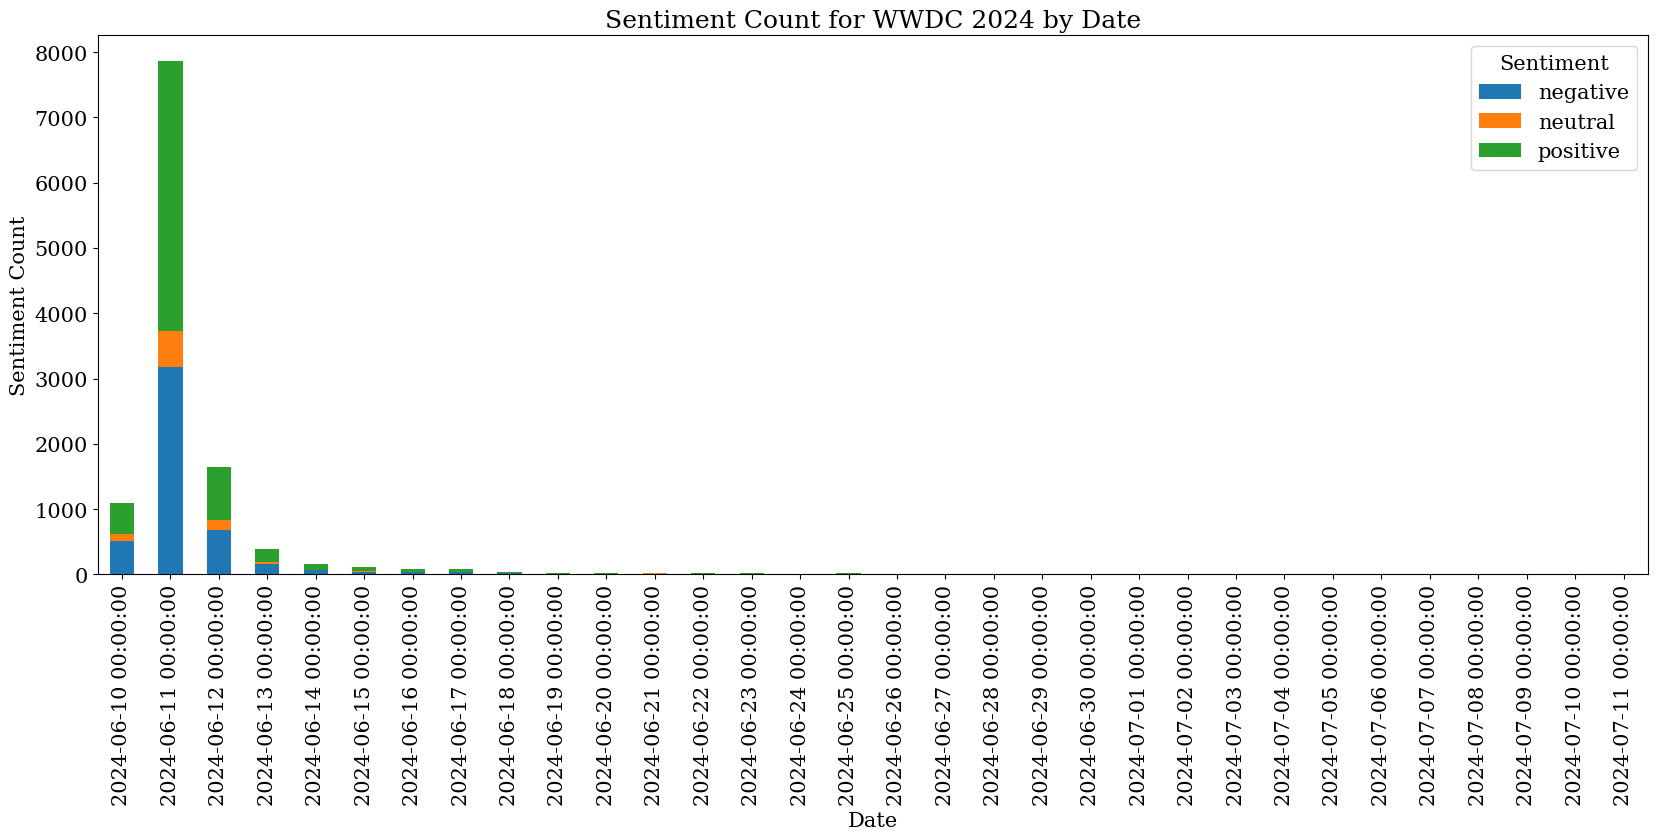

In [82]:
# For YouTube and Reddit users

# Group by hf sentiment label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(20, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

(The axis is somewhat skewed by one date.) Most comments made on 6.11.24. And there is almost a split in sentiment between positive and negative. Mostly positive across days. Let's take a look at the emotion breakdown. 

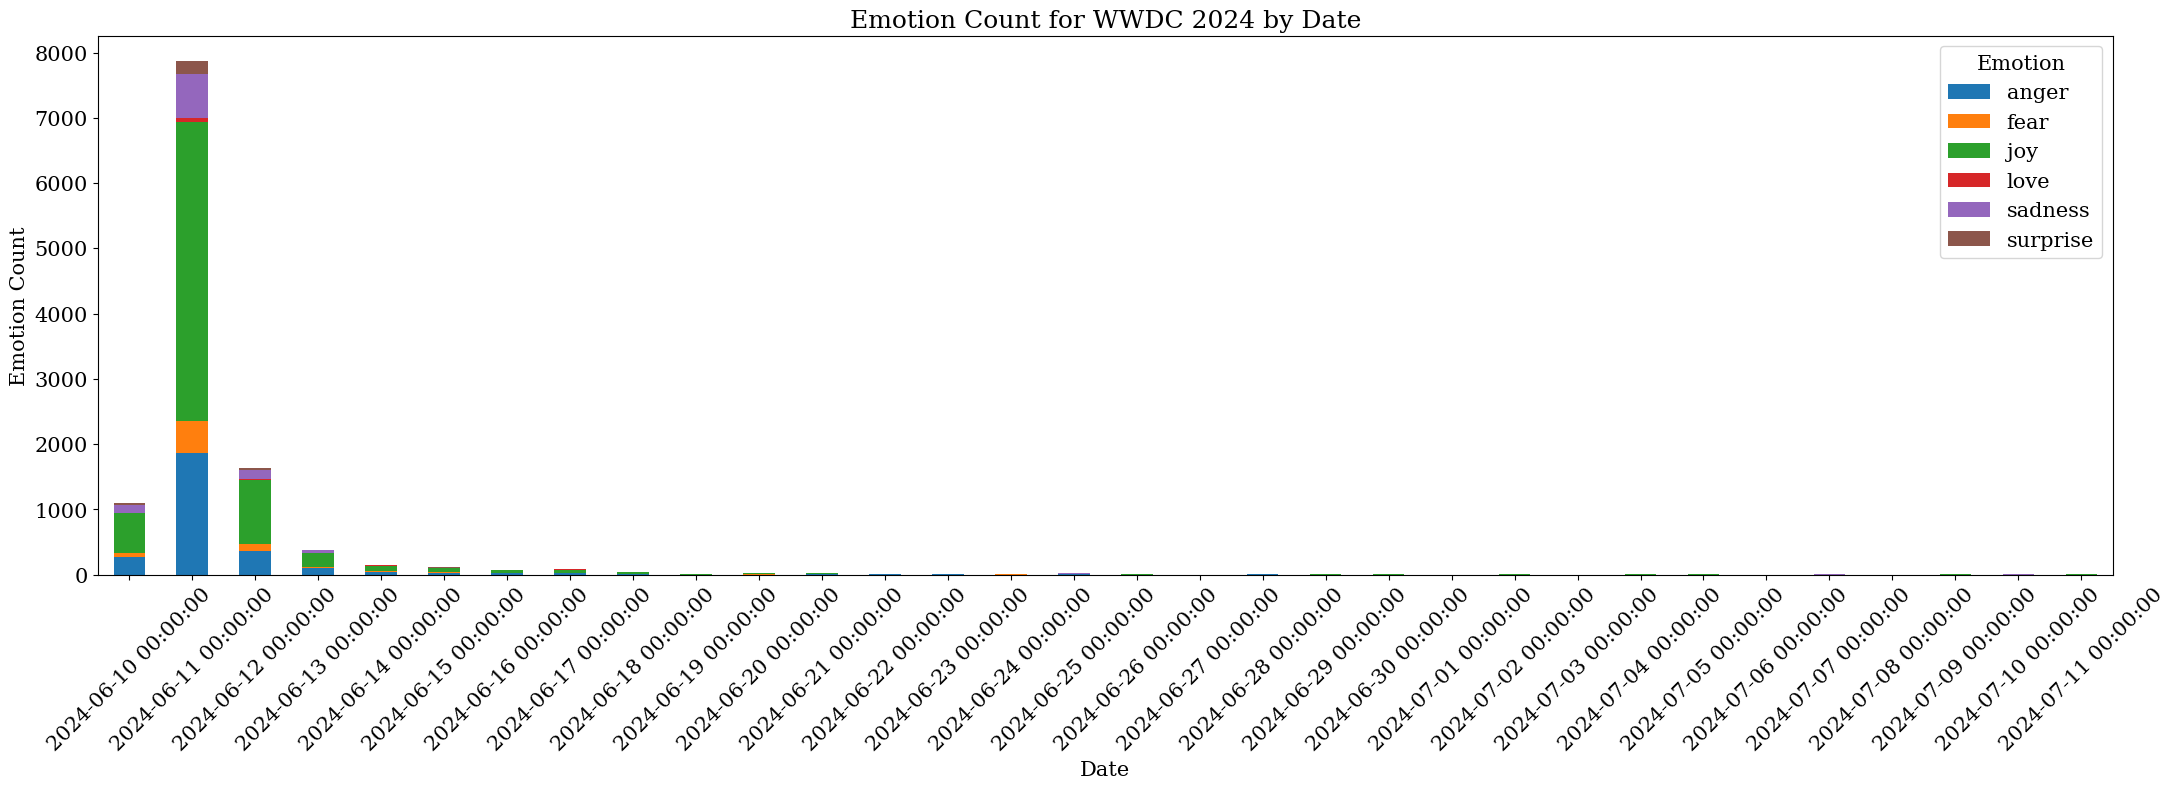

In [83]:
# Group by hf emotion label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.show()

(The axis is somewhat skewed by one date again.) With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA)
Trying to get more granular with sentiment analysis. E.g. What particular aspects from comments/features lead to joy/anger?

## Using General Aspect Extractor

In [84]:
# just pick a sample from df to perform general aspect-based sentiment analysis to see its performance
inf_df2_percent = inf_df2.sample(frac=0.01)
inf_df2_percent = inf_df2_percent.reset_index(drop=True)
len(inf_df2_percent)

116

In [85]:
# Let us try HuggingFace model for Aspect Based Sentiment Analysis

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [86]:
%%time

aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

inf_df2_percent['absa_gen'] = inf_df2_percent.apply(lambda row: absa_general(row['final_text']), axis=1)

CPU times: user 30min 54s, sys: 3.15 s, total: 30min 58s
Wall time: 15min 29s


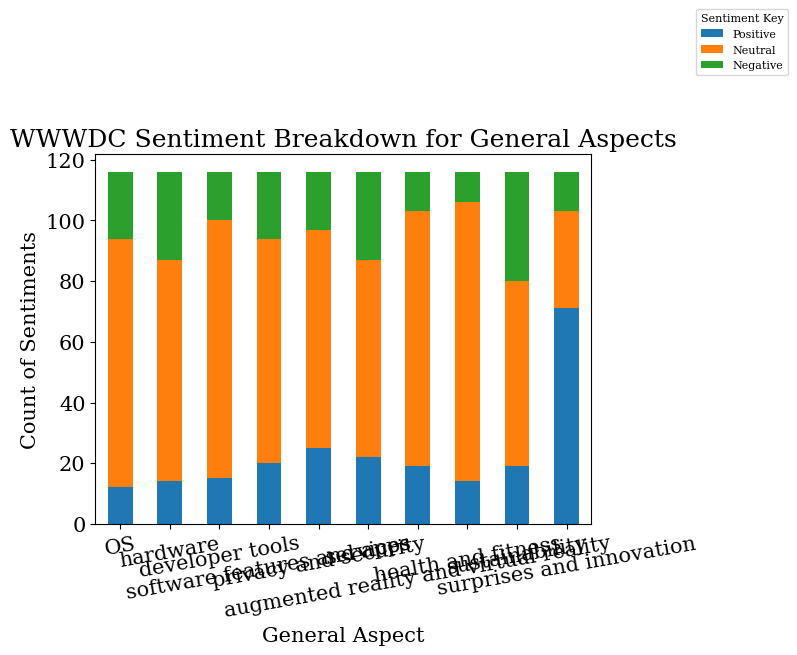

In [87]:
# Extract keys and create new columns
for key in inf_df2_percent['absa_gen'][0].keys():
    inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = inf_df2_percent[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('WWWDC Sentiment Breakdown for General Aspects')
plt.xlabel('General Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation= 10)
plt.rcParams["figure.figsize"] = (15,3)
plt.rcParams.update({'font.size': 8})


# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.2, 1.2), loc='lower left')

# Adjust the layout to make room for the legend
# plt.tight_layout()

# Show the plot
plt.show()

## Using PyABSA

In [88]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-13 00:06:01] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-13 00:06:01] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-13 00:06:01] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-13 00:06:01] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-13 00:06:18] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-13 00:06:18] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-13 00:06:18] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-13 00:06:18] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-13 00:06:18] (2.4.1.post1) model: None
[2024-07-13 00:06:18] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-13 0

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



___
## PyABSA on whole df would take approximately 8 hours to run and possibly cause notebook to crash.

In [89]:
# create blank df to add subsequent df's to it
# loop through each 117 100-row df's
# add new PyABSA prediction column
# concat all 117 df's together

# df0 = pd.DataFrame()
# for df in tqdm_notebook(list_df, desc="PROGRESS"):
    
#     df['absa_sp'] = df['final_text'].apply(lambda x: absa_sp([x]))
#     df0 = pd.concat([df0, df])
    
# df0.info()

___

In [90]:
%%time

# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


inf_df2_percent['absa_sp'] = inf_df2_percent['final_text'].apply(lambda x: absa_sp([x]))

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-07-13 00:06:28] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 00:06:28] (2.4.1.post1) Example 0: he reading the apple script on an android
[2024-07-13 00:06:31] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 00:06:31] (2.4.1.post1) Example 0: i noticed all the siri pop up doesn ’ t use the dynamic island , which seems a shame . but could this mean the <iphone:Neutral Confidence:0.9992> 16 will be shifting away from it with a new design ?
[2024-07-13 00:06:34] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 00:06:34] (2.4.1.post1) Example 0: * no - - its not legit . *
[2024-07-13 00:06:39] (2.4.1.p

In [91]:
def aspect(x):
    return list(x.values())

def aspect_sentiment(x):
    return list(x.keys())

In [92]:
inf_df2_percent['aspect'] = inf_df2_percent.apply(lambda row: aspect(row['absa_sp']), axis=1)
inf_df2_percent['aspect'] = inf_df2_percent['aspect'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent.apply(lambda row: aspect_sentiment(row['absa_sp']), axis=1)
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.lower()
inf_df2_percent.drop(columns=['absa_sp'], inplace=True)

In [93]:
inf_df2_percent.head()

author  like_count  \
0  @LegoStopMotionDude           0   
1       @frostburnwoof           0   
2           @AnonZero0           0   
3     @lNoWayAroundItl           0   
4     @caseyhouser9839           0   

                                                                                                                                                           original_text  \
0                                                                                                                              He reading the apple script on an android   
1  I noticed all the Siri pop up doesn’t use the Dynamic Island, which seems a shame. But could this mean the iPhone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *No--its not legit.*   
3                                   I just want a simple opt out option to anything generative AI. I don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      Don’t want any AI   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-11  YouTube   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                              final_text  \
0                                                                                                                              he reading the apple script on an android   
1  i noticed all the siri pop up doesn’t use the dynamic island, which seems a shame. but could this mean the iphone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *no--its not legit.*   
3                                   i just want a simple opt out option to anything generative ai. i don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      don’t want any ai   

  hf_sentiment  hf_score hf_emotion  \
0     positive  0.488598       fear   
1     negative  0.762489        joy   
2      neutral  0.481059      anger   
3      neutral  0.534916      anger   
4      neutral  0.463951      anger   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0           {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Negative', 'software features and apps': 'Negative', 'privacy and security': 'Negative', 'services': 'Negative', 'augmented reality and virtual reality': 'Negative', 'health and fitness': 'Negative', 'sustainab

### Auditing PyABSA Inference

In [94]:
inf_df2_percent.head()

author  like_count  \
0  @LegoStopMotionDude           0   
1       @frostburnwoof           0   
2           @AnonZero0           0   
3     @lNoWayAroundItl           0   
4     @caseyhouser9839           0   

                                                                                                                                                           original_text  \
0                                                                                                                              He reading the apple script on an android   
1  I noticed all the Siri pop up doesn’t use the Dynamic Island, which seems a shame. But could this mean the iPhone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *No--its not legit.*   
3                                   I just want a simple opt out option to anything generative AI. I don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      Don’t want any AI   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-11  YouTube   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                              final_text  \
0                                                                                                                              he reading the apple script on an android   
1  i noticed all the siri pop up doesn’t use the dynamic island, which seems a shame. but could this mean the iphone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *no--its not legit.*   
3                                   i just want a simple opt out option to anything generative ai. i don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      don’t want any ai   

  hf_sentiment  hf_score hf_emotion  \
0     positive  0.488598       fear   
1     negative  0.762489        joy   
2      neutral  0.481059      anger   
3      neutral  0.534916      anger   
4      neutral  0.463951      anger   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0           {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Negative', 'software features and apps': 'Negative', 'privacy and security': 'Negative', 'services': 'Negative', 'augmented reality and virtual reality': 'Negative', 'health and fitness': 'Negative', 'sustainab

In [95]:
inf_df2_percent.tail()

author  like_count  \
111      williagh           3   
112  @Chris-ht5ng           0   
113      @cwbibbs           0   
114      @Want300          33   
115    @gosuprime           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     original_text  \
111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    They said they had a way to keep CGPT interactions private.   
112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Breakfast and MKBHD 🙏   
113                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             For the new AirPod features, is it just on the 2nd gen pros? I'm assuming 1st gen won't support it   
114                                                                                                                                                                                                                                                                                                                                                                                                                                                      They need to make photos allow me to combine family photos... where one kid smiles, the other isn't looking, and vice versa. Rarely get both to cooperate   
115  The ONLY reason OpenAI would help Apple is because they want your private data for training AI models.  Trust me, I know how to make them.  It's not to help you or make your life more productive.  They want your data.  Except if openAI app is always active, guess what it's also doing?  Logging your private convos, habits, user data, trends, banking info, whatever.  All which can be used by OpenAI to train or refine existing models.  Please don't buy into the crap that openAI is here for philanthropy, they are a "non profit" business that just happens to be fully funded by Microsoft.   

    published_at_date      app  \
111        2024-06-10   Reddit   
112        2024-06-11  YouTube   
113        2024-06-11  YouTube   
114        2024-06-10  YouTube   
115        2024-06-11  YouTube   

                  

Small sample, but PyABSA is somewhat more accurate than emotion classifier and much better than sentiment classifier. Pretty spot-on with most aspects though. Groq still wins though. :)

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

## POC:

In [96]:
content = '''
apple intelligence coping android and samsung ai. very intelligent. 2.0update. just go android 
and youll get 100% custumization not just 10% with iphone. in android samsung tablet s9ultra 
we have myscript calculator app and does very advanced calculations with samsung s pen does all 
your math homework and we had this app for 7yrs ago so bravo now u have a calculator app on ipad m4. 
man apple users get so exited for stuff we had for years on android. exept wen apple users always 
think oh apple does it better yea right... no brain.
'''

doc = nlp(content)

for ent in doc.ents:
	print(ent.text, ent.start_char, ent.end_char, ent.label_)

samsung 39 46 ORG
100% 111 115 PERCENT
just 10% 134 142 PERCENT
android samsung 159 174 ORG
s9ultra 182 189 LAW
samsung s pen 264 277 PERSON
7yrs ago 331 339 DATE
m4 385 387 GPE
years 441 446 DATE
wen apple 465 474 PERSON


In [97]:
displacy.render(doc, style="ent")

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [98]:
entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
ner_df

text     type            lemma
0          samsung      ORG          samsung
1             100%  PERCENT             100%
2         just 10%  PERCENT         just 10%
3  android samsung      ORG  android samsung
4          s9ultra      LAW          s9ultra
5    samsung s pen   PERSON    samsung s pen
6         7yrs ago     DATE          7yr ago
7               m4      GPE               m4
8            years     DATE             year
9        wen apple   PERSON        wen apple

The type and lemma are rough. There is better output from Aspect Based Sentiment Analysis where aspects are drawn out. And sentiment is tied to it.

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: number likes, sentiment/emotion 
* compare YouTube and Reddit comments across like count (popularity) and overall sentiment (choose more accurate classifier: absa) and overall emotion

* First pass: to see how Radar Graph works
1. [x] preview like count across YouTube and Reddit
1. [x] pick best overall sentiment classifier (Groq) FOR NOW, PyABSA is more accurate than emotion classifier on overall comment
1. [x] will need to transform sentiment classification into grades
1. [x] create Radar graph to see how each social media platforms' sentiment compares across different metrics

* Second pass: Examine most talked about releases and sentiment tied to it
1. [x] grab data from absa sp
1. [x] do an aggregation with aspect for sentiment and popularity (like rating, num reviews)

In [99]:
inf_df2_percent.head(1)

author  like_count                              original_text  \
0  @LegoStopMotionDude           0  He reading the apple script on an android   

  published_at_date      app                                 final_text  \
0        2024-06-11  YouTube  he reading the apple script on an android   

  hf_sentiment  hf_score hf_emotion  \
0     positive  0.488598       fear   

                                                                                                                                                                                                                                                                                                                              absa_gen  \
0  {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}   

   ... developer tools software features and apps privacy and security  \
0  ...         Neutral                    Neutral              Neutral   

  services augmented reality and virtual reality health and fitness  \
0  Neutral                               Neutral            Neutral   

  sustainability surprises and innovation   aspect aspect_sentiment  
0        Neutral                 Positive  android          neutral  

[1 rows x 22 columns]

In [100]:
query = """
select app
, sum(like_count) as total_liked_comments
from inf_df2_percent
group by 1
"""

duckdb.query(query).df()

app  total_liked_comments
0   Reddit                 856.0
1  YouTube                 165.0

A lot more activity on YouTube

In [101]:
query = """
select app 
, hf_emotion
, count(hf_emotion) as total_emotion_count
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app hf_emotion  total_emotion_count
0  YouTube        joy                   58
1  YouTube      anger                   29
2  YouTube       fear                   11
3   Reddit        joy                    8
4   Reddit      anger                    4
5   Reddit    sadness                    3
6  YouTube    sadness                    3

Across both social media platforms, comments are dominated by joy then anger.

In [102]:
query = """
select app
, aspect
, count(aspect) as total_aspects
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app                aspect  total_aspects
0   YouTube                                   29
1   YouTube                iphone             10
2   YouTube                 apple              8
3    Reddit                                    5
4   YouTube                  ipad              4
5   YouTube                 icons              3
6   YouTube               android              2
7   YouTube              internet              2
8   YouTube                   ios              2
9   YouTube               samsung              2
10  YouTube                  icon              2
11  YouTube               privacy              2
12   Reddit                server              1
13  YouTube            aesthetics              1
14  YouTube               youtube              1
15   Reddit               iphones              1
16   Reddit                    os              1
17   Reddit                  tech              1
18  YouTube         videoskeynote              1
19  YouTube                 views              1
20  YouTube       androidfeatures              1
21  YouTube                 notes              1
22  YouTube                window              1
23  YouTube              updating              1
24  YouTube                  list              1
25   Reddit                  your              1
26   Reddit                  same              1
27  YouTube  to get it ! 👎👎👎👎👎👎👎👎              1
28  YouTube                search              1
29  YouTube              security              1
30   Reddit                  news              1
31  YouTube               marques              1
32  YouTube                 drone              1
33  YouTube             breakfast              1
34  YouTube                images              1
35  YouTube            steve jobs              1
36  YouTube                  wwdc              1
37   Reddit              security              1
38  YouTube               locking              1
39  YouTube                  math              1
40  YouTube                 title              1
41  YouTube         color palette              1
42   Reddit                ipados              1
43  YouTube             grammarly              1
44  YouTube               carplay              1
45  YouTube             recording              1
46  YouTube                 ipads              1
47  YouTube               mr musk              1
48  YouTube               twitter              1
49  YouTube              features              1
50  YouTube            calculator              1
51  YouTube                tinder              1
52   Reddit              tracking              1
53  YouTube                rabbit              1
54  YouTube               channel              1
55  YouTube                   uis              1
56  YouTube              platform              1

A lot of comments had unknown sentiment, which is good to know. With comments that were easily classified though, PyABSA produced negative for YouTube's top sentiment and neutral for Reddit's top sentiment.

In [103]:
# Creating grades from sentiments - only using emotion, and aspect based sentiment classification

query = """
select *
, case when hf_emotion IN ('anger', 'fear') then 1
when hf_emotion IN ('sadness', 'surprise') then 2
when hf_emotion IN ('joy', 'love') then 3
else 0
end as emotion_grade
, case when aspect_sentiment = 'negative' then 1
when aspect_sentiment = 'neutral' then 2
when aspect_sentiment = 'positive' then 3
else 0
end as aspect_sentiment_grade
from inf_df2_percent
"""

inf_df2_percent_grades = duckdb.query(query).df()
inf_df2_percent_grades.head()

author  like_count  \
0  @LegoStopMotionDude           0   
1       @frostburnwoof           0   
2           @AnonZero0           0   
3     @lNoWayAroundItl           0   
4     @caseyhouser9839           0   

                                                                                                                                                           original_text  \
0                                                                                                                              He reading the apple script on an android   
1  I noticed all the Siri pop up doesn’t use the Dynamic Island, which seems a shame. But could this mean the iPhone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *No--its not legit.*   
3                                   I just want a simple opt out option to anything generative AI. I don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      Don’t want any AI   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-11  YouTube   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                              final_text  \
0                                                                                                                              he reading the apple script on an android   
1  i noticed all the siri pop up doesn’t use the dynamic island, which seems a shame. but could this mean the iphone 16 will be shifting away from it with a new design?   
2                                                                                                                                                   *no--its not legit.*   
3                                   i just want a simple opt out option to anything generative ai. i don't need to complain about it if there was the ability to choose.   
4                                                                                                                                                      don’t want any ai   

  hf_sentiment  hf_score hf_emotion  \
0     positive  0.488598       fear   
1     negative  0.762489        joy   
2      neutral  0.481059      anger   
3      neutral  0.534916      anger   
4      neutral  0.463951      anger   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0           {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Negative', 'software features and apps': 'Negative', 'privacy and security': 'Negative', 'services': 'Negative', 'augmented reality and virtual reality': 'Negative', 'health and fitness': 'Negative', 'sustainab

In [104]:
# get relevant columns (app, num likes, emotion_grade, aspect_sentiment_grade) and set app as index

query = """
select app
, round(avg(like_count)) as avg_like_count
, round(avg(emotion_grade)) as avg_emotion
, round(avg(aspect_sentiment_grade)) as avg_aspect_sentiment
from inf_df2_percent_grades
group by 1
"""

radar_df = duckdb.query(query).df()

# Set app as index
radar_df.set_index('app', inplace=True)
radar_df

avg_like_count  avg_emotion  avg_aspect_sentiment
app                                                       
YouTube             2.0          2.0                   1.0
Reddit             57.0          2.0                   1.0

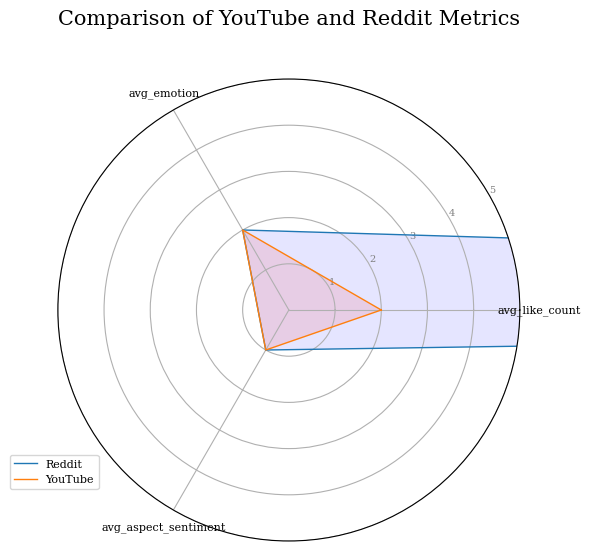

In [105]:
# Data preparation
labels = list(radar_df)
stats_reddit = radar_df.loc['Reddit'].tolist()
stats_youtube = radar_df.loc['YouTube'].tolist()

# Completing the loop
stats_reddit += stats_reddit[:1]
stats_youtube += stats_youtube[:1]

# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw y-labels
ax.set_rlabel_position(30)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=7) #this may need to be generarlized due to hard-coding axis for metrics
plt.ylim(0, 5)

# Plot data
ax.plot(angles, stats_reddit, linewidth=1, linestyle='solid', label='Reddit')
ax.fill(angles, stats_reddit, 'b', alpha=0.1)

ax.plot(angles, stats_youtube, linewidth=1, linestyle='solid', label='YouTube')
ax.fill(angles, stats_youtube, 'r', alpha=0.1)

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(0.1, 0.1))

# Title
plt.title('Comparison of YouTube and Reddit Metrics', size=15, color='black', y=1.1)

# Show plot
plt.show()

Based on this, we see that Reddit wins over YouTube with popularity votes. Would be nice to see what exactly are  the most popular comments.

# Most popular topics and emotion sentiment across YouTube and Reddit

In [106]:
query = """
select aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
"""

duckdb.query(query).df()

aspect  total_occurence
0                 iphone               10
1                  apple                8
2                   ipad                4
3                  icons                3
4                android                2
5               internet                2
6               security                2
7                    ios                2
8                samsung                2
9                   icon                2
10               privacy                2
11                server                1
12         videoskeynote                1
13                 views                1
14       androidfeatures                1
15            aesthetics                1
16               twitter                1
17              features                1
18               iphones                1
19                    os                1
20                  tech                1
21            calculator                1
22                tinder                1
23                rabbit                1
24               channel                1
25                  wwdc                1
26                  your                1
27               locking                1
28                  math                1
29                  same                1
30                  list                1
31  to get it ! 👎👎👎👎👎👎👎👎                1
32                search                1
33                ipados                1
34               marques                1
35                 title                1
36         color palette                1
37                  news                1
38             grammarly                1
39               carplay                1
40             recording                1
41                 ipads                1
42               mr musk                1
43                   uis                1
44              platform                1
45               youtube                1
46                 notes                1
47                window                1
48              tracking                1
49              updating                1
50                images                1
51            steve jobs                1
52                 drone                1
53             breakfast                1

We can see here that past the high-level topic of apple, most talked about WWDC topics were iphone, Siri iPad and features in general. Given the long tail, there needs to be more data. 

In [107]:
# Overall sentiment of most talked about topics from WWDC

query = """

with cte as (
select aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
)

select aspect
, aspect_sentiment
from inf_df2_percent
where aspect in (select aspect from cte limit 8) 
and aspect != 'alibaba' --noise
"""

inf_df2_percent_as = duckdb.query(query).df()
inf_df2_percent_as

aspect aspect_sentiment
0    android          neutral
1     iphone          neutral
2   internet         negative
3   security         negative
4     iphone          neutral
5      apple          neutral
6      icons         negative
7      apple         negative
8        ios          neutral
9     iphone          neutral
10    iphone          neutral
11    iphone          neutral
12    iphone          neutral
13  internet         negative
14      ipad          neutral
15      ipad         negative
16     icons         negative
17     icons         positive
18     apple         negative
19      ipad          neutral
20    iphone         positive
21   android         positive
22  security         negative
23    iphone          neutral
24       ios          neutral
25     apple          neutral
26    iphone          neutral
27     apple          neutral
28      ipad          neutral
29    iphone          neutral
30     apple          neutral
31     apple         positive
32     apple         negative

In [108]:
# Create the sunburst chart
fig = px.sunburst(
    inf_df2_percent_as,
    path=['aspect', 'aspect_sentiment'],
    color='aspect_sentiment',
    color_discrete_map={'positive':'green', 'neutral':'grey', 'negative':'red'},
    title='Sentiment Analysis of Most Talked About Topics'
)

# Show the plot
fig.show()

At the center, we can see the most talked about topics across YouTube and Reddit. The outer layer shows the different sentiments per topic. And for each sentiment, the most popular and least popular sentiment per topic with not much positive sentiment. The only aspect that was not mostly negative nor netural was apps. This means if this is consistent across samples of data, Apple really needs to up their WoW factor.

It looks like from the WWDC conference, phones: iphone and android were the most talked about topics. 